In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Data preparation function
def prepare_data(ticker, sequence_length=24):
    """
    Prepare hourly stock data for LSTM
    sequence_length: number of hours to look back (24 = 1 day of trading)
    """
    # Load hourly data
    df = pd.read_csv(f'Stock Data Hourly/{ticker}_hourly.csv')
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Select features (OHLCV)
    features = ['open', 'high', 'low', 'close', 'volume']
    data = df[features].values
    
    # Normalize data (important for neural networks)
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(len(data_normalized) - sequence_length):
        X.append(data_normalized[i:i+sequence_length])  # Past 24 hours
        y.append(data_normalized[i+sequence_length, 3])  # Next hour's close price
    
    X = np.array(X)
    y = np.array(y)
    
    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False  # Don't shuffle time series!
    )
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    y_test = torch.FloatTensor(y_test).to(device)
    
    return X_train, X_test, y_train, y_test, scaler

# Test data preparation
ticker = "RELIANCE"
X_train, X_test, y_train, y_test, scaler = prepare_data(ticker)
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: torch.Size([9022, 24, 5])
Test data shape: torch.Size([2256, 24, 5])


In [4]:
# LSTM Model Definition
class StockLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, 1)  # Predict single value (close price)
        
    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)
        
        # Take output from last time step
        last_output = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()

# Initialize model
model = StockLSTM(input_size=5, hidden_size=64, num_layers=2).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

StockLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 53569


In [5]:
# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_train)
        loss = criterion(predictions, y_train)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test)
            test_loss = criterion(test_predictions, y_test)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}")
    
    return train_losses, test_losses

# Train the model
train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test, epochs=50)

Epoch [10/50] - Train Loss: 0.094245, Test Loss: 0.242166
Epoch [20/50] - Train Loss: 0.057863, Test Loss: 0.021980
Epoch [30/50] - Train Loss: 0.021333, Test Loss: 0.002035
Epoch [40/50] - Train Loss: 0.013484, Test Loss: 0.006218
Epoch [50/50] - Train Loss: 0.009970, Test Loss: 0.001336


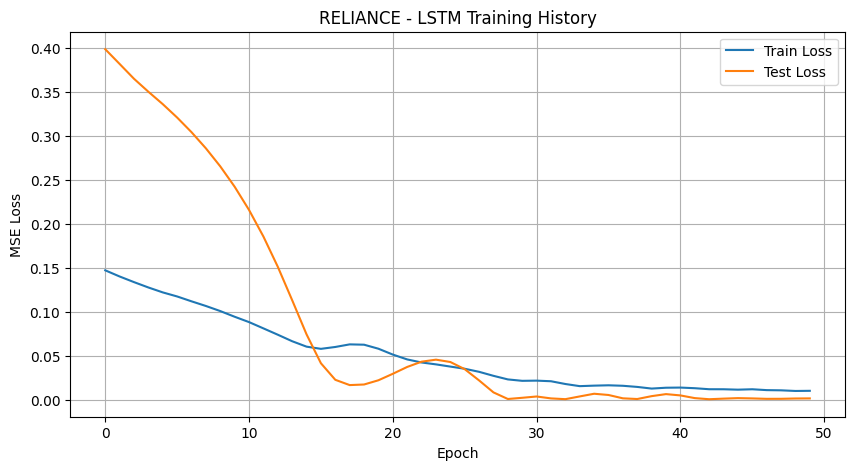

In [6]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f'{ticker} - LSTM Training History')
plt.legend()
plt.grid(True)
plt.show()


RELIANCE Model Performance:
MAE: ₹65.66
RMSE: ₹79.33
MAPE: 2.70%


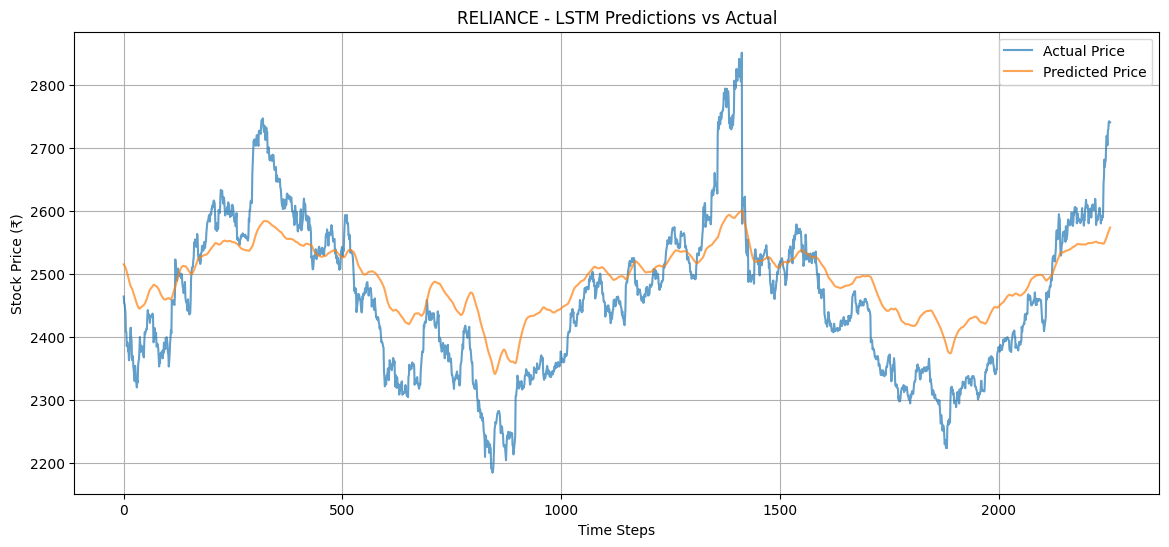

In [7]:
# Evaluation and visualization
model.eval()
with torch.no_grad():
    predictions = model(X_test).cpu().numpy()
    actuals = y_test.cpu().numpy()

# Denormalize predictions to actual prices
# We need to reverse the scaling for close price (index 3)
dummy = np.zeros((len(predictions), 5))
dummy[:, 3] = predictions
predictions_actual = scaler.inverse_transform(dummy)[:, 3]

dummy[:, 3] = actuals
actuals_actual = scaler.inverse_transform(dummy)[:, 3]

# Calculate metrics
mae = np.mean(np.abs(predictions_actual - actuals_actual))
rmse = np.sqrt(np.mean((predictions_actual - actuals_actual)**2))
mape = np.mean(np.abs((actuals_actual - predictions_actual) / actuals_actual)) * 100

print(f"\n{ticker} Model Performance:")
print(f"MAE: ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(14, 6))
plt.plot(actuals_actual, label='Actual Price', alpha=0.7)
plt.plot(predictions_actual, label='Predicted Price', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price (₹)')
plt.title(f'{ticker} - LSTM Predictions vs Actual')
plt.legend()
plt.grid(True)
plt.show()